## Задание:

1. На том же наборе данных, что и в предыдущем задании, провести feature engineering:

создать Weights of Evidence (WOE) фичи на тех переменных, где категорий большое количество
cделать one hot encoding там, где необходимо
по желанию посчитать каунты (counts)
2. Обучить linear SVM и SVM с нелинейным ядром — сравнить время обучения и результат метрики оценки качества (ROC AUC) двух алгоритмов между собой и сравнить с линейной моделью (лог.рег).



In [395]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import time
import datetime
from datetime import date
import time
from datetime import datetime, date, time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 8)
from mpl_toolkits.mplot3d import axes3d
matplotlib.rcParams['figure.figsize'] = (20, 8)
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, auc
import json
%config InlineBackend.figure_format = 'retina'

In [396]:
def to_date( row ):
    formatter_string = "%d.%m.%Y"
    datetime_object = datetime.strptime(row['CURR_DATE'], formatter_string)
    return datetime_object

def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_auc_score(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

def get_woe(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test

def get_counts(df_train, df_test, col, target_col):
    category_val_dict = (
        df_train[ df_train[target_col] == 1 ][col].value_counts()
        /
        df_train[col].value_counts()
    ).to_dict()
    df_train.loc[:, col + '_counts'] = df_train[col].apply(category_val_dict.get)
    df_test.loc[:, col + '_counts'] = df_test[col].apply(category_val_dict.get)
    return df_train, df_test

def get_one_hot(df, cols):
    
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

# Загрузка данных

In [397]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## WOE и Counts

In [398]:
for column in ['MCC', 'trx_category', 'currency']:
    train_df, test_df = get_counts(train_df, test_df, column, 'target_flag')
    train_df, test_df = get_woe(train_df, test_df, column, 'target_flag')

In [399]:
train_full_df = pd.concat([train_df, test_df])
train_full_df.head(5)

,MCC,MCC_counts,MCC_woe,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,currency_counts,currency_woe,target_flag,target_sum,trx_category,trx_category_counts,trx_category_woe
0,5200,0.493353,-0.657027,01/10/2017,21OCT17:00:00:00,5023.0,NaN,0,810,0.651584,-0.004428,0.0,0.0,POS,0.655573,0.013192
1,6011,0.653231,0.002836,01/10/2017,12OCT17:12:24:07,20000.0,NaN,0,810,0.651584,-0.004428,0.0,0.0,DEPOSIT,0.466629,-0.764118
2,5921,0.672651,0.089764,01/12/2017,05DEC17:00:00:00,767.0,NaN,0,810,0.651584,-0.004428,0.0,0.0,POS,0.655573,0.013192
3,5411,0.619393,-0.143462,01/10/2017,21OCT17:00:00:00,2031.0,NaN,0,810,0.651584,-0.004428,0.0,0.0,POS,0.655573,0.013192
4,6012,0.567721,-0.357878,01/10/2017,24OCT17:13:14:24,36562.0,NaN,0,810,0.651584,-0.004428,0.0,0.0,C2C_OUT,0.672654,0.089778


## Парсинг даты

In [400]:
train_full_df.drop('target_sum', axis=1, inplace=True)

#Обработка даты
train_full_df.PERIOD = pd.to_datetime(train_full_df.PERIOD, format='%d/%m/%Y')
train_full_df.TRDATETIME = pd.to_datetime(train_full_df.TRDATETIME, format='%d%b%y:%H:%M:%S')
train_full_df['Day'] = train_full_df.TRDATETIME.dt.weekday  # Weekday as a decimal number, where 0 is Sunday and 6 is Saturday.
train_full_df['Weekend'] = train_full_df.Day.isin({'6', '0'}).map({False: '0', True: '1'})  # Выходные
train_full_df['Month'] = train_full_df.TRDATETIME.dt.month  # Month as a decimal number. (Platform specific)
train_full_df['Hour'] = train_full_df.TRDATETIME.dt.hour  # Hour (24-hour clock) as a decimal number. (Platform specific)
train_full_df.head()



,MCC,MCC_counts,MCC_woe,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,currency_counts,currency_woe,target_flag,trx_category,trx_category_counts,trx_category_woe,Day,Weekend,Month,Hour
0,5200,0.493353,-0.657027,2017-10-01,2017-10-21 00:00:00,5023.0,NaN,0,810,0.651584,-0.004428,0.0,POS,0.655573,0.013192,5,0,10,0
1,6011,0.653231,0.002836,2017-10-01,2017-10-12 12:24:07,20000.0,NaN,0,810,0.651584,-0.004428,0.0,DEPOSIT,0.466629,-0.764118,3,0,10,12
2,5921,0.672651,0.089764,2017-12-01,2017-12-05 00:00:00,767.0,NaN,0,810,0.651584,-0.004428,0.0,POS,0.655573,0.013192,1,0,12,0
3,5411,0.619393,-0.143462,2017-10-01,2017-10-21 00:00:00,2031.0,NaN,0,810,0.651584,-0.004428,0.0,POS,0.655573,0.013192,5,0,10,0
4,6012,0.567721,-0.357878,2017-10-01,2017-10-24 13:14:24,36562.0,NaN,0,810,0.651584,-0.004428,0.0,C2C_OUT,0.672654,0.089778,1,0,10,13


## Список категорий

In [401]:
trx_all_type_list = list(train_full_df.trx_category.unique())
trx_all_type_list

['POS',
 'DEPOSIT',
 'C2C_OUT',
 'WD_ATM_ROS',
 'BACK_TRX',
 'WD_ATM_PARTNER',
 'WD_ATM_OTHER',
 'C2C_IN',
 'CAT',
 'CASH_ADV']

In [402]:
train_full_df['channel_type'].fillna('type0', inplace=True)
train_full_df['TRDATETIME'].fillna('0-0-0 00:00:00', inplace=True)
train_full_df.head(5)

,MCC,MCC_counts,MCC_woe,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,currency_counts,currency_woe,target_flag,trx_category,trx_category_counts,trx_category_woe,Day,Weekend,Month,Hour
0,5200,0.493353,-0.657027,2017-10-01,2017-10-21 00:00:00,5023.0,type0,0,810,0.651584,-0.004428,0.0,POS,0.655573,0.013192,5,0,10,0
1,6011,0.653231,0.002836,2017-10-01,2017-10-12 12:24:07,20000.0,type0,0,810,0.651584,-0.004428,0.0,DEPOSIT,0.466629,-0.764118,3,0,10,12
2,5921,0.672651,0.089764,2017-12-01,2017-12-05 00:00:00,767.0,type0,0,810,0.651584,-0.004428,0.0,POS,0.655573,0.013192,1,0,12,0
3,5411,0.619393,-0.143462,2017-10-01,2017-10-21 00:00:00,2031.0,type0,0,810,0.651584,-0.004428,0.0,POS,0.655573,0.013192,5,0,10,0
4,6012,0.567721,-0.357878,2017-10-01,2017-10-24 13:14:24,36562.0,type0,0,810,0.651584,-0.004428,0.0,C2C_OUT,0.672654,0.089778,1,0,10,13


In [403]:
#оценим распределение категорий
train_full_df.trx_category.value_counts(normalize=True)

POS               0.851009
DEPOSIT           0.042706
WD_ATM_ROS        0.038076
WD_ATM_PARTNER    0.020248
C2C_IN            0.015062
WD_ATM_OTHER      0.013993
C2C_OUT           0.011111
BACK_TRX          0.005385
CAT               0.002337
CASH_ADV          0.000072
Name: trx_category, dtype: float64

In [404]:
channel_type_list = list(train_full_df.channel_type.unique())
channel_type_list

['type0', 'type5', 'type4', 'type2', 'type3', 'type1']

In [405]:
mapping = dict(zip(['type0', 'type5', 'type4', 'type2', 'type3', 'type1'], ['0','5','4','2','3','1']))
train_full_df.channel_type = train_full_df.channel_type.replace(mapping)

## Обработка валют

In [406]:
currency_df = pd.read_excel('curr_rates.xlsx', columns = '')
currency_df.head()

,CODE,NUM_ISO_CODE,CURRNAME,CURR_DATE,RATE
0,INR,356,Индийская рупия,22.03.2017,0.876687
1,EUR,978,Евро,22.03.2017,61.730800
2,HUF,348,Венгерский форинт,22.03.2017,0.200095
3,AMD,51,Армянский драм,22.03.2017,0.118371
4,TJS,972,Таджикский сомони,22.03.2017,7.033160


In [407]:
currency_df['Date'] = currency_df.apply( to_date, axis = 1 )
del currency_df['CURR_DATE']
currency_df.head()

,CODE,NUM_ISO_CODE,CURRNAME,RATE,Date
0,INR,356,Индийская рупия,0.876687,2017-03-22
1,EUR,978,Евро,61.730800,2017-03-22
2,HUF,348,Венгерский форинт,0.200095,2017-03-22
3,AMD,51,Армянский драм,0.118371,2017-03-22
4,TJS,972,Таджикский сомони,7.033160,2017-03-22


In [408]:
train_full_df = pd.merge( train_full_df , currency_df, how='left', left_on=['currency','TRDATETIME'], right_on=['NUM_ISO_CODE','Date'])

train_full_df['RATE'].fillna(1, inplace=True)
train_full_df['amount'] = train_full_df.amount * train_full_df.RATE


del train_full_df['RATE']
del train_full_df['NUM_ISO_CODE']
del train_full_df['CURRNAME']
del train_full_df['Date']

train_full_df['currency'].fillna('1', inplace=True)
train_full_df['amount'].fillna('1.0', inplace=True)
train_full_df['MCC'].fillna('1', inplace=True)
train_full_df['cl_id'].fillna('1', inplace=True)
train_full_df['trx_category'].fillna('No', inplace=True)




train_full_df.head(5)

,MCC,MCC_counts,MCC_woe,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,currency_counts,currency_woe,target_flag,trx_category,trx_category_counts,trx_category_woe,Day,Weekend,Month,Hour,CODE
0,5200,0.493353,-0.657027,2017-10-01,2017-10-21 00:00:00,5023.0,0,0,810,0.651584,-0.004428,0.0,POS,0.655573,0.013192,5,0,10,0,NaN
1,6011,0.653231,0.002836,2017-10-01,2017-10-12 12:24:07,20000.0,0,0,810,0.651584,-0.004428,0.0,DEPOSIT,0.466629,-0.764118,3,0,10,12,NaN
2,5921,0.672651,0.089764,2017-12-01,2017-12-05 00:00:00,767.0,0,0,810,0.651584,-0.004428,0.0,POS,0.655573,0.013192,1,0,12,0,NaN
3,5411,0.619393,-0.143462,2017-10-01,2017-10-21 00:00:00,2031.0,0,0,810,0.651584,-0.004428,0.0,POS,0.655573,0.013192,5,0,10,0,NaN
4,6012,0.567721,-0.357878,2017-10-01,2017-10-24 13:14:24,36562.0,0,0,810,0.651584,-0.004428,0.0,C2C_OUT,0.672654,0.089778,1,0,10,13,NaN


In [409]:
mcc_df = pd.read_excel('mcc-codes.xlsx')
mcc_df  = mcc_df.drop_duplicates(keep = False)
mcc_df.head(5)


,mcc,description,category
0,742,Ветеринарные услуги,Контрактные услуги
1,763,Сельскохозяйственные кооперативы,Контрактные услуги
2,780,Ландшафтные и садоводческие магазины,Контрактные услуги
3,1520,Генеральные подрядчики – жилищное и торговое с...,Контрактные услуги
4,1711,"Генеральные подрядчики по вентиляции, теплосна...",Контрактные услуги


## Загрузка значений кодов

In [410]:
mcc_df.category.where(~mcc_df.category.isnull(), mcc_df.description, inplace=True)

mcc_df.category = LabelEncoder().fit_transform(mcc_df.category.astype(str))
# mcc.category.value_counts() # Категорий немного и номера у них небольшие

mapping = dict(zip(mcc_df.mcc, mcc_df.category))
train_full_df['MccCategory'] = train_full_df.MCC.map(mapping)  # Map создаст NaN там, где нет замены

train_full_df.drop(train_full_df[ train_full_df.MccCategory.isna() ].index, axis=0, inplace=True)

del train_full_df['MccCategory']

In [411]:
train_full_df.head(5)

,MCC,MCC_counts,MCC_woe,PERIOD,TRDATETIME,amount,channel_type,cl_id,currency,currency_counts,currency_woe,target_flag,trx_category,trx_category_counts,trx_category_woe,Day,Weekend,Month,Hour,CODE
0,5200,0.493353,-0.657027,2017-10-01,2017-10-21 00:00:00,5023.0,0,0,810,0.651584,-0.004428,0.0,POS,0.655573,0.013192,5,0,10,0,NaN
1,6011,0.653231,0.002836,2017-10-01,2017-10-12 12:24:07,20000.0,0,0,810,0.651584,-0.004428,0.0,DEPOSIT,0.466629,-0.764118,3,0,10,12,NaN
2,5921,0.672651,0.089764,2017-12-01,2017-12-05 00:00:00,767.0,0,0,810,0.651584,-0.004428,0.0,POS,0.655573,0.013192,1,0,12,0,NaN
3,5411,0.619393,-0.143462,2017-10-01,2017-10-21 00:00:00,2031.0,0,0,810,0.651584,-0.004428,0.0,POS,0.655573,0.013192,5,0,10,0,NaN
4,6012,0.567721,-0.357878,2017-10-01,2017-10-24 13:14:24,36562.0,0,0,810,0.651584,-0.004428,0.0,C2C_OUT,0.672654,0.089778,1,0,10,13,NaN


In [412]:
train_full_df.amount.unique()

array([ 5023.  , 20000.  ,   767.  , ...,  7337.7 ,   137.16,  6133.6 ])

## Построим матрицу корреляции

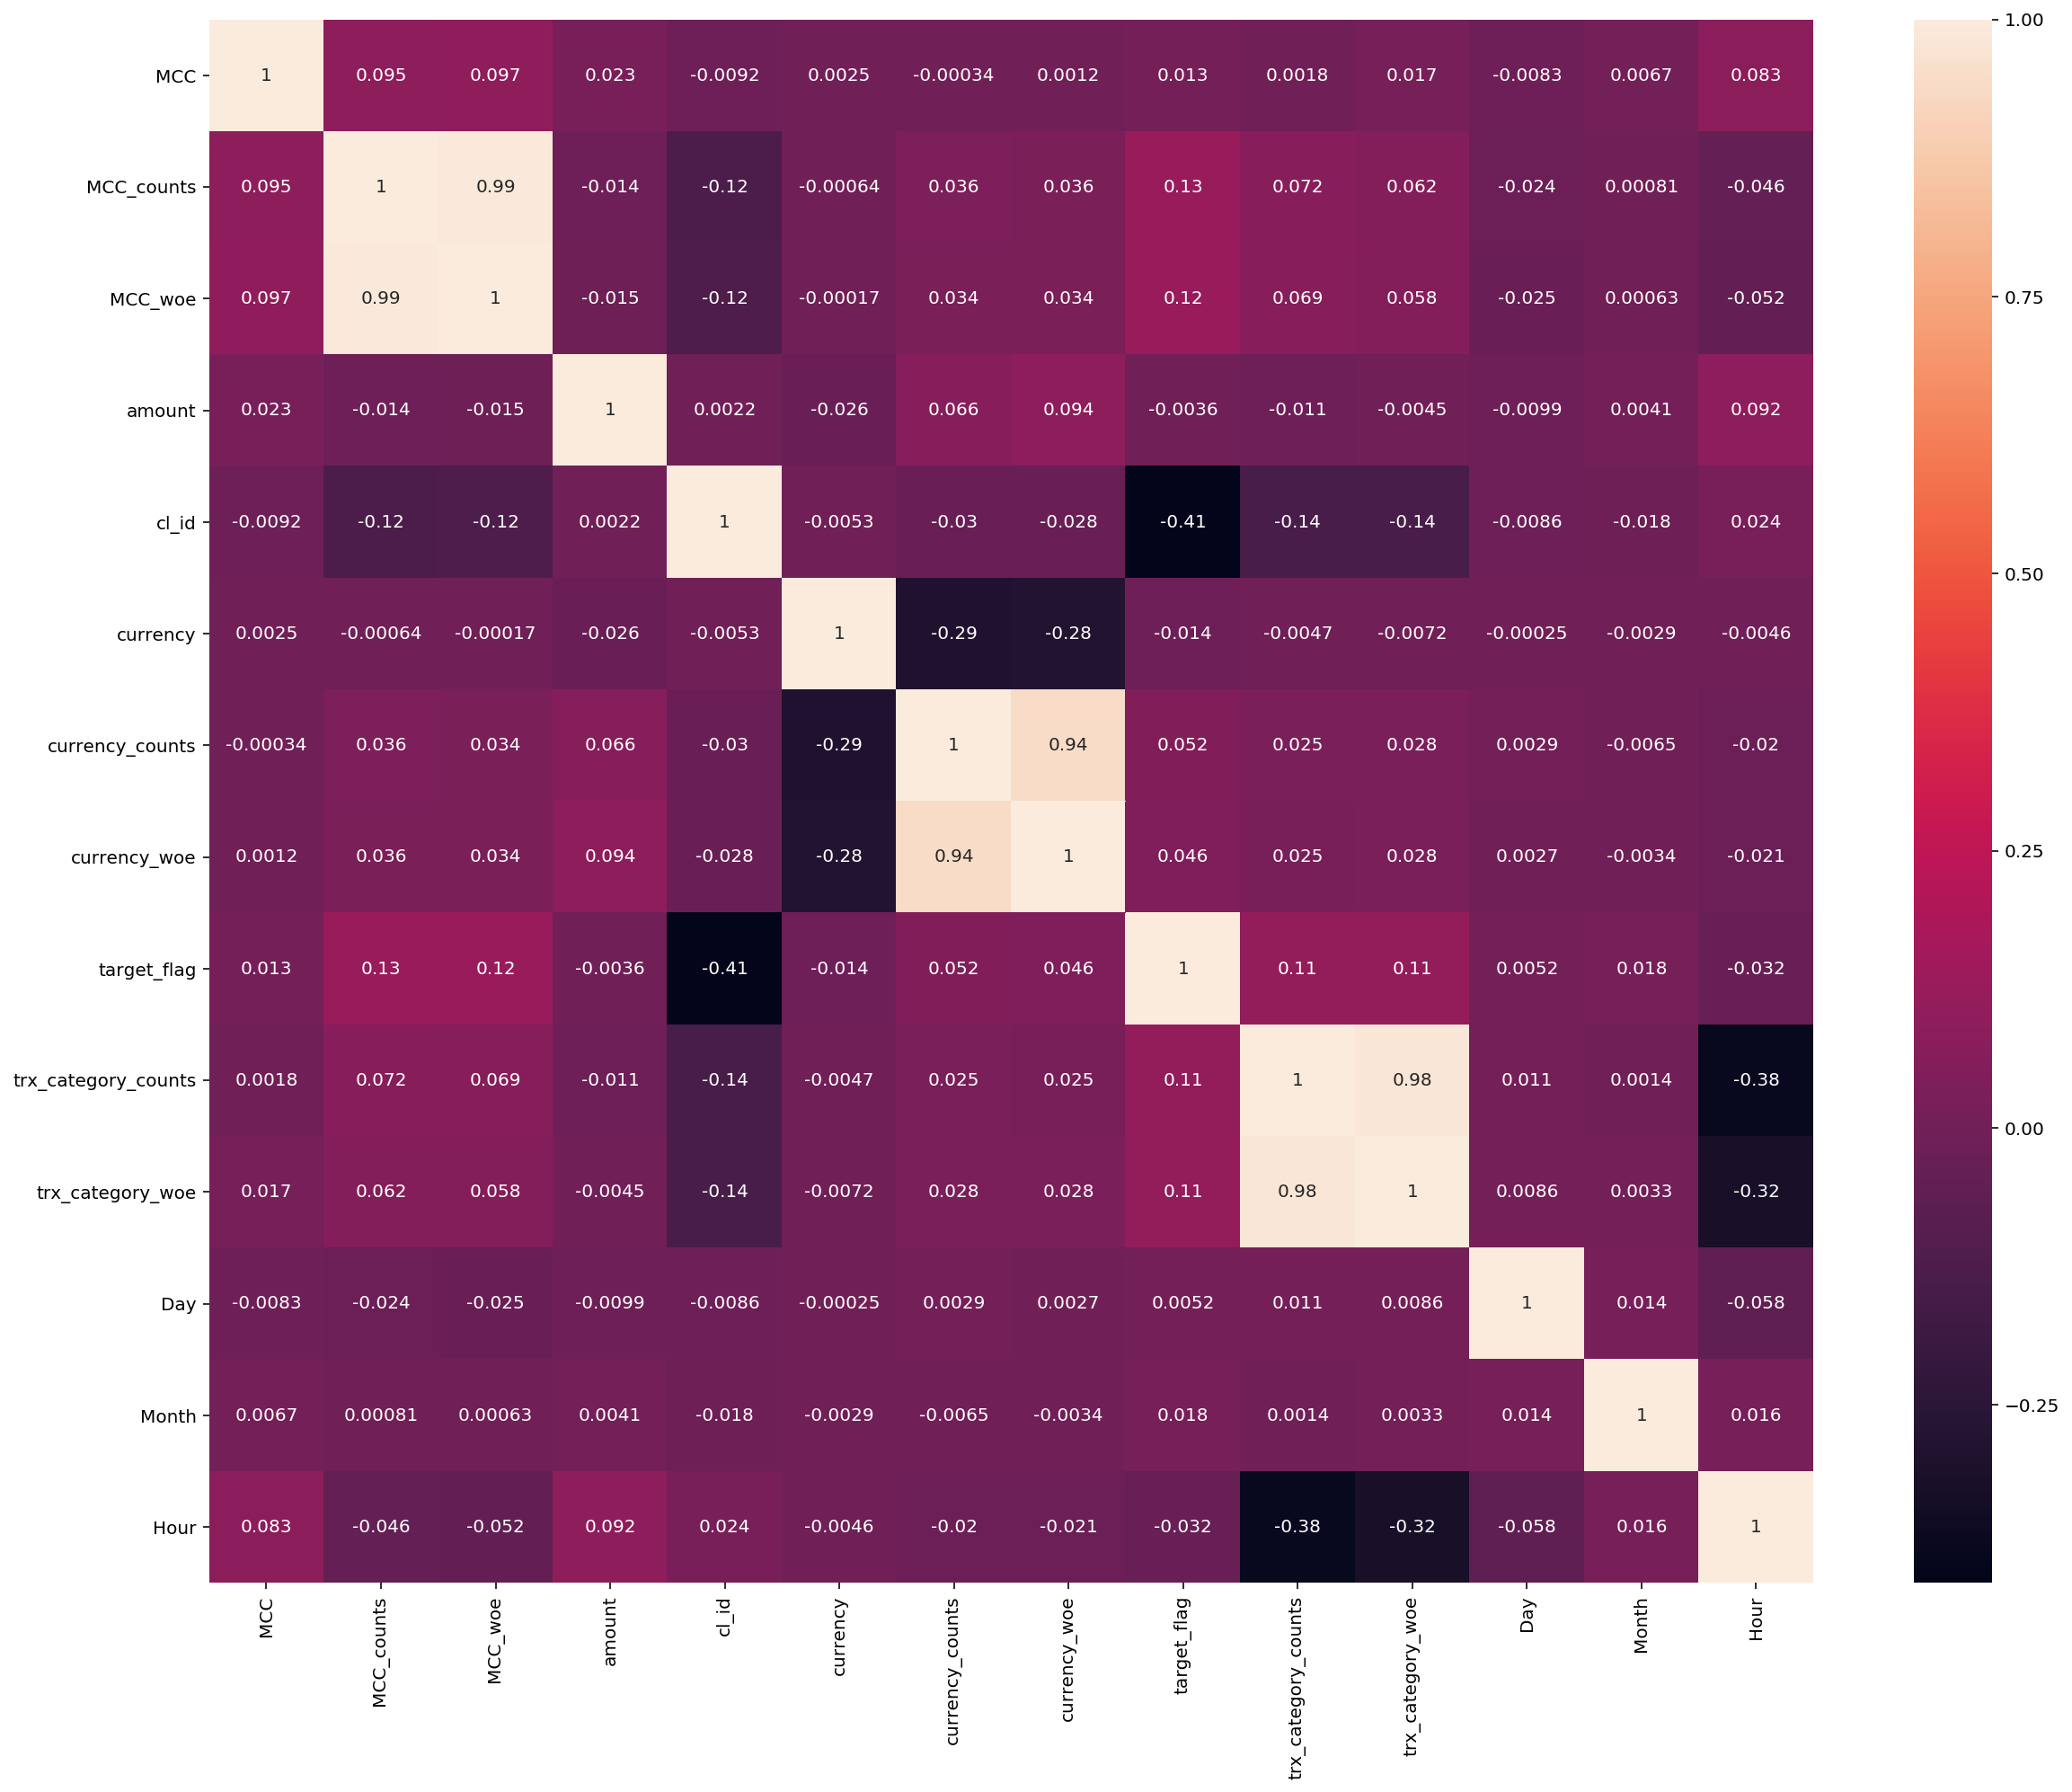

In [413]:
plt.figure(figsize=(20, 16))

corr = train_full_df.corr()
sns.heatmap(corr, annot=True, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Обработка данных

In [414]:
del train_full_df['CODE']
#del train_full_df['TRDATETIME']


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_full_df_labeled = train_full_df.copy()
train_full_df_labeled['PERIOD']            = le.fit_transform(train_full_df_labeled['PERIOD'])
train_full_df_labeled['MCC']               = le.fit_transform(train_full_df_labeled['MCC'])
train_full_df_labeled['MCC_counts']               = le.fit_transform(train_full_df_labeled['MCC_counts'])
train_full_df_labeled['MCC_woe']               = le.fit_transform(train_full_df_labeled['MCC_woe'])
train_full_df_labeled['currency']          = le.fit_transform(train_full_df_labeled['currency'])
train_full_df_labeled['currency_counts']          = le.fit_transform(train_full_df_labeled['currency_counts'])
train_full_df_labeled['currency_woe']          = le.fit_transform(train_full_df_labeled['currency_woe'])
train_full_df_labeled['channel_type']      = le.fit_transform(train_full_df_labeled['channel_type'])
train_full_df_labeled['trx_category']      = le.fit_transform(train_full_df_labeled['trx_category'])
train_full_df_labeled['trx_category_counts']      = le.fit_transform(train_full_df_labeled['trx_category_counts'])
train_full_df_labeled['trx_category_woe']      = le.fit_transform(train_full_df_labeled['trx_category_woe'])
train_full_df_labeled['target_flag']       = le.fit_transform(train_full_df_labeled['target_flag'])
train_full_df_labeled['amount']            = le.fit_transform(train_full_df_labeled['amount'])
train_full_df_labeled['cl_id']             = le.fit_transform(train_full_df_labeled['cl_id'])
train_full_df_labeled['Weekend']             = le.fit_transform(train_full_df_labeled['Weekend'])
train_full_df_labeled['TRDATETIME']        = le.fit_transform(train_full_df_labeled['TRDATETIME'])

In [415]:
train_full_df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008887 entries, 0 to 1008888
Data columns (total 19 columns):
MCC                    1008887 non-null int64
MCC_counts             1008887 non-null int64
MCC_woe                1008887 non-null int64
PERIOD                 1008887 non-null int64
TRDATETIME             1008887 non-null int64
amount                 1008887 non-null int64
channel_type           1008887 non-null int64
cl_id                  1008887 non-null int64
currency               1008887 non-null int64
currency_counts        1008887 non-null int64
currency_woe           1008887 non-null int64
target_flag            1008887 non-null int64
trx_category           1008887 non-null int64
trx_category_counts    1008887 non-null int64
trx_category_woe       1008887 non-null int64
Day                    1008887 non-null int64
Weekend                1008887 non-null int64
Month                  1008887 non-null int64
Hour                   1008887 non-null int64
dtypes: int64

## Разделяем выборки

In [416]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
y = train_full_df_labeled['target_flag']
train_full_df_labeled.drop(columns='target_flag', inplace=True)

In [417]:

X_train, X_test, Y_train, Y_test = train_test_split(train_full_df_labeled[::200], y[::200], test_size=0.2)


In [418]:
#Шкалирование данных
from sklearn.preprocessing import StandardScaler
st = StandardScaler()
X_train_st = st.fit_transform(X_train)
X_test_st = st.transform(X_test)
X_train = pd.DataFrame(X_train_st, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_st, columns=X_test.columns, index=X_test.index)

In [419]:
X_train.shape, X_test.shape

((4036, 18), (1009, 18))

## Применение Lasso

In [420]:
lasso =  Lasso();
lasso.fit(X_train, Y_train);

In [421]:
print('R^2 is {}'.format(lasso.score(X_train, Y_train)))

R^2 is 0.08367058674127847


In [422]:
lasso.coef_

array([-3.46688488e+03, -1.16276292e+03, -5.21503721e-11, -7.25953004e+03,
        2.98904295e+03, -3.54909200e+03,  6.31105680e+03, -4.38102228e+04,
        6.80125229e+03,  6.51599577e+03,  4.08466922e+02, -1.69842140e+03,
        4.43328438e+03,  2.99980017e-12, -2.62116674e+02, -1.95130489e+03,
        5.80601961e+01,  8.97577993e+02])

In [423]:
lasso.intercept_

135132.14841427156

In [424]:
pca = PCA().fit(X_train,Y_train)

Text(0,0.5,'explained_variance_ratio')

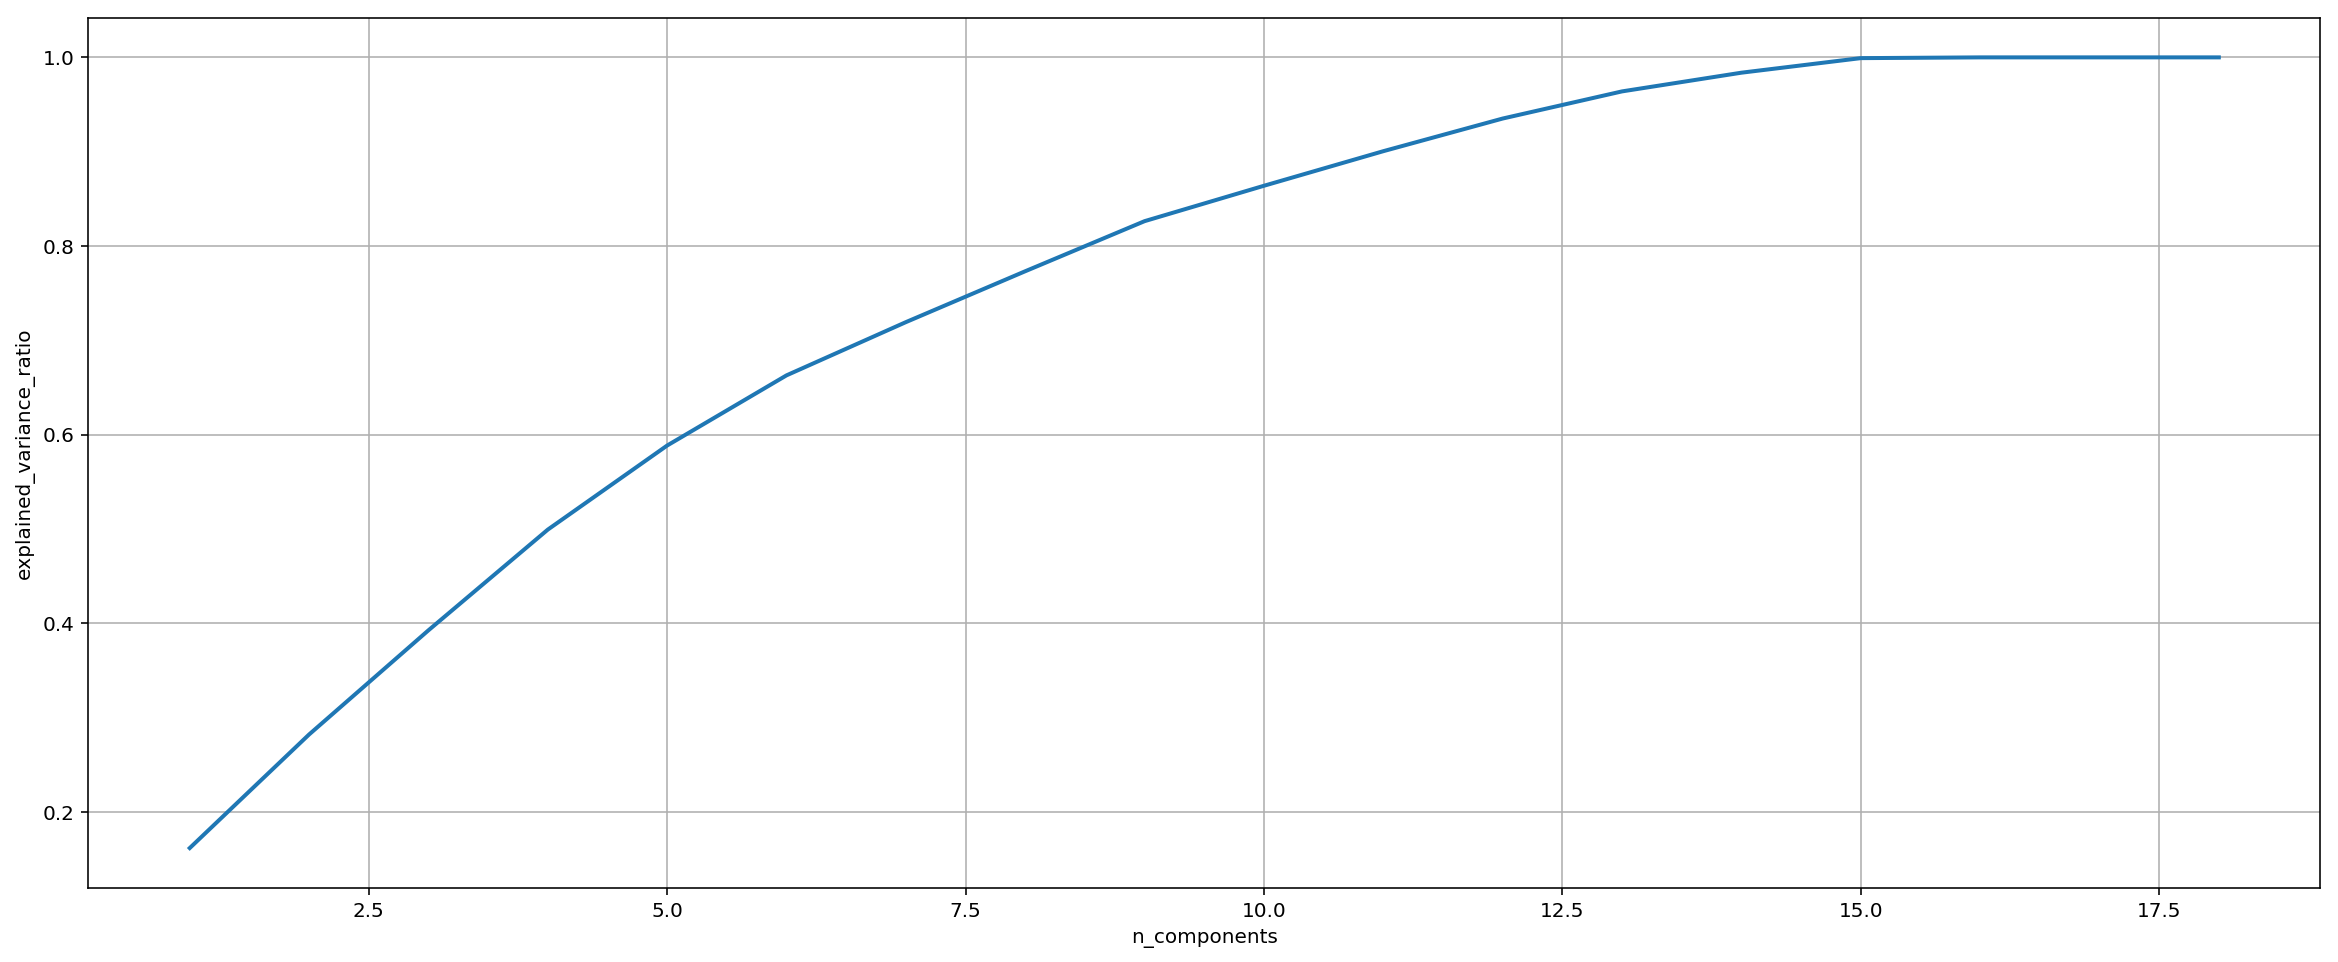

In [425]:
cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio')

In [426]:
X_train_pca = pca.transform(X_train)
X_train_pca

array([[-1.74783959e+00, -1.81620864e+00, -5.34129645e-01, ...,
         1.32847776e-03,  7.56339436e-16,  5.55111512e-16],
       [ 1.91429133e+00,  1.02051631e+00,  8.23603001e-01, ...,
        -8.67300090e-02, -5.55111512e-17,  4.44089210e-16],
       [-4.06381836e-01,  2.15170060e+00, -1.28566968e+00, ...,
        -1.17979706e-01,  3.33066907e-16,  1.11022302e-15],
       ...,
       [ 2.31432056e+00, -5.18427027e-01, -4.75362374e-01, ...,
         5.41539019e-02,  6.66133815e-16,  2.49800181e-16],
       [-4.80017276e-01, -1.62753885e+00,  1.57797441e+00, ...,
        -9.93688844e-03, -4.71844785e-16,  7.77156117e-16],
       [-1.74947937e+00, -1.25293187e+00, -7.73191600e-01, ...,
         7.67438402e-02,  3.81639165e-16, -4.44089210e-16]])

In [427]:
X_test_pca = pca.transform(X_test)

In [428]:
Y_train.shape, X_train_pca.shape

((4036,), (4036, 18))

## SVM

In [429]:
%%time
from sklearn import svm
svm_clf = svm.SVC(C=4)
svm_clf.fit(X_train_pca, Y_train)

Wall time: 22.7 s


In [430]:
svm_clf.fit(X_test_pca, Y_test)

SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [432]:
y_pred_svm_clf_train = svm_clf.predict(X_train_pca)
y_pred_svm_clf_test = svm_clf.predict(X_test_pca)

In [435]:
print("Accuracy score", accuracy_score(Y_train, y_pred_svm_clf_train))
print("Accuracy score", accuracy_score(Y_test, y_pred_svm_clf_test))

Accuracy score 0.31491575817641226
Accuracy score 0.5322101090188305


## Leaner SVM

In [440]:
%%time
from sklearn.svm import LinearSVC
svm_clf =LinearSVC(C=10, loss="hinge", random_state=42)
svm_clf.fit(X_train_pca, Y_train)

Wall time: 48.8 s


In [441]:
%%time
svm_clf.fit(X_test_pca, Y_test)

Wall time: 3.31 s


LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0)

In [442]:
y_pred_svm_clf_train = svm_clf.predict(X_train_pca)
y_pred_svm_clf_test = svm_clf.predict(X_test_pca)

In [443]:
print("Accuracy score", accuracy_score(Y_train, y_pred_svm_clf_train))
print("Accuracy score", accuracy_score(Y_test, y_pred_svm_clf_test))

Accuracy score 0.06863230921704658
Accuracy score 0.2933597621407334


## Logistic Regression

In [444]:
%%time
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_pca,Y_train)

Wall time: 41.8 s


In [445]:
lr.fit(X_test_pca,Y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [446]:
y_pred_lr_train = lr.predict(X_train_pca)
y_pred_lr_test = lr.predict(X_test_pca)

In [447]:
print("Accuracy score", accuracy_score(Y_train, y_pred_svm_clf_train))
print("Accuracy score", accuracy_score(Y_test, y_pred_svm_clf_test))

Accuracy score 0.06863230921704658
Accuracy score 0.2933597621407334
